# PyTorch Neural Network Classification

## Types of classification problems

In binary classification, target values can be one of two types.  
In multiclass classification, target values can be one of multiple types.
In multilabel classification, each target can be assigned multiple categories.

## Architechture of a classification neural network

Neural networks consist of an input layer, output layer, and several hidden layers.  
Hidden layers typically use the ReLU activation function, whereas output layers use sigmoid for binary classification and softmax for multiclass classification.  
Hidden layers consist of anywhere between `10` and `512` neurons, whereas output layers consist of `1` neuron for binary classification and one for each class for multiclass classification.  
`torch.nn.BCELoss` is used for binary classification and `torch.nn.CrossEntropy` for multiclass classification.  
SGD and Adam are the most widely-used optimizers. 

## Preparing data

In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

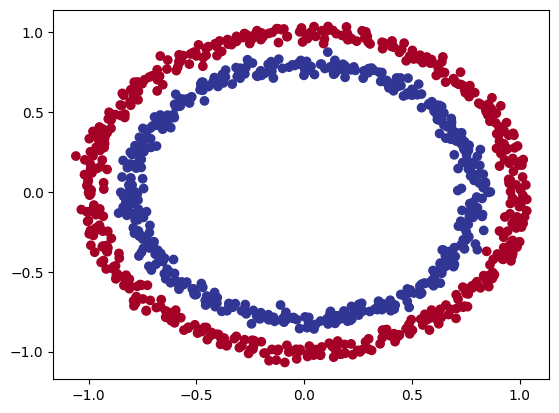

In [2]:
X, y = make_circles(1000, noise=0.03, random_state=42)
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [3]:
import torch
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

## Building a model

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
class CircleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = torch.nn.Linear(in_features=2, out_features=10)
        self.layer_2 = torch.nn.Linear(in_features=10, out_features=10)
        self.layer_3 = torch.nn.Linear(in_features=10, out_features=1)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

`BCELoss` and `BCELossWithLogits` are used for binary classification.  
`CrossEntropyLoss` is used for multi-class classification.  
`L1Loss` (mean absolute error) and `MSELoss` (mean squared error) are used for regression.

`BCEWithLogitsLoss` computes loss after considering an additional sigmoid layer after the output.  
It is equivalent to using `BCELoss` on a network whose last layer is sigmoid, but is more numerically stable.  
However, for advanced usage, cases could arise where we would want to separate the sigmoid layer from the loss function; in such cases `BCELoss` is used.

In [7]:
model = CircleModel().to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

An evaluation metric is the opposite of loss - it is a measure of how well a model is performing.  
Accuracy is an evaluation metric - it is the fraction of predictions that were correct.

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Training

In [9]:
torch.manual_seed(42)
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

The sigmoid activation function converts logits (raw data) into data that can be interpreted in a meaningful way in the context of binary classification.  
The result of the function is a number from `0` to `1` - a form which is comparable to our required output.  
Consequently, the loss is computed with respect to the sigmoid data and not on logits directly.

In [10]:
for epoch in range(epochs):
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.71505 | Accuracy: 50.00% | Test loss: 0.71274 | Test accuracy: 50.00
Epoch: 100 | Loss: 0.69281 | Accuracy: 49.38% | Test loss: 0.69342 | Test accuracy: 50.50
Epoch: 200 | Loss: 0.69145 | Accuracy: 51.50% | Test loss: 0.69218 | Test accuracy: 51.50
Epoch: 300 | Loss: 0.69001 | Accuracy: 53.62% | Test loss: 0.69089 | Test accuracy: 52.50
Epoch: 400 | Loss: 0.68832 | Accuracy: 56.00% | Test loss: 0.68942 | Test accuracy: 54.00
Epoch: 500 | Loss: 0.68636 | Accuracy: 60.38% | Test loss: 0.68786 | Test accuracy: 57.50
Epoch: 600 | Loss: 0.68411 | Accuracy: 62.50% | Test loss: 0.68627 | Test accuracy: 59.00
Epoch: 700 | Loss: 0.68147 | Accuracy: 60.62% | Test loss: 0.68462 | Test accuracy: 57.50
Epoch: 800 | Loss: 0.67823 | Accuracy: 57.50% | Test loss: 0.68263 | Test accuracy: 57.00
Epoch: 900 | Loss: 0.67441 | Accuracy: 55.88% | Test loss: 0.68030 | Test accuracy: 55.50


## Plotting results

`helper_functions.py` is a file that contains the `plot_predictions` and `plot_decision_boundary` functions.  
The following code downloads the file from the internet.

In [11]:
import requests
from pathlib import Path

In [12]:
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [13]:
from helper_functions import plot_decision_boundary

In [14]:
model.eval()
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model(X_test).squeeze()))

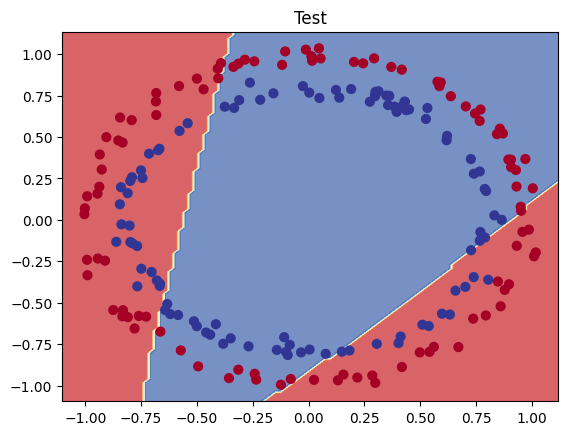

In [15]:
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## Replicating non-linear activation functions

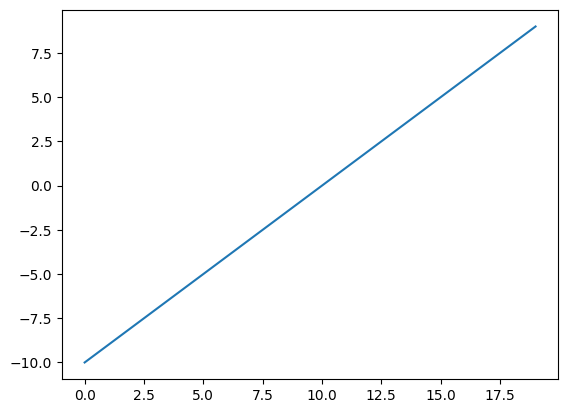

In [16]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A)

In [17]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

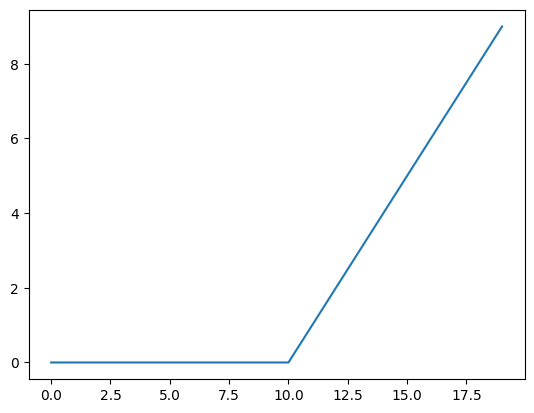

In [18]:
plt.plot(relu(A))

In [19]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

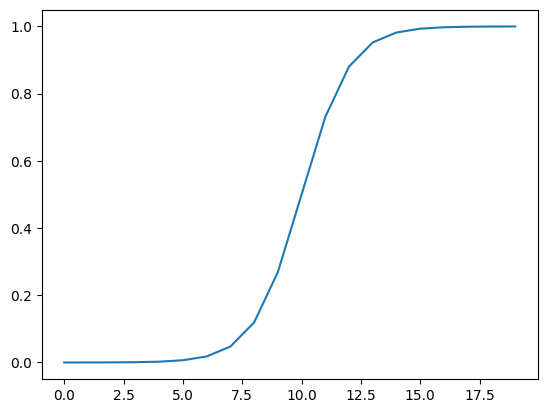

In [20]:
plt.plot(sigmoid(A))

## Multi-class classification

In [21]:
from sklearn.datasets import make_blobs

The `centers` attribute of `make_blobs()` takes the required number of blobs, whereas `cluster_std` is used to introduce randomness.  
As `y_train` and `y_test` are tensors containing labels, they have to be converted to `torch.LongTensor` and not `torch.float32`.

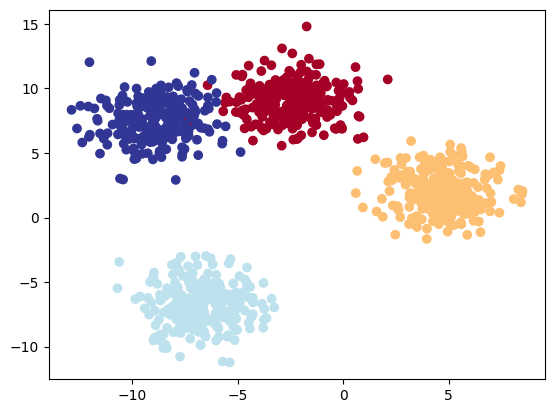

In [22]:
X_blob, y_blob = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)
X_train, y_train = torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(y_train).type(torch.LongTensor)
X_test, y_test = torch.from_numpy(X_test).type(torch.float32), torch.from_numpy(y_test).type(torch.LongTensor)
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [23]:
class BlobModel(torch.nn.Module):
    def __init__(self, input_features, output_features, hidden_features=8):
        super().__init__()
        self.linear_layer_stack = torch.nn.Sequential(
            torch.nn.Linear(in_features=input_features, out_features=hidden_features),
            torch.nn.Linear(in_features=hidden_features, out_features=hidden_features),
            torch.nn.Linear(in_features=hidden_features, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

In [24]:
model = BlobModel(2, 4).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [25]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [26]:
torch.manual_seed(42)
epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

The `torch.softmax()` and `torch.argmax()` methods have a `dim` attribute which is used to specify the dimension along which the operation has to be performed.

In [27]:
for epoch in range(epochs):
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | Test loss: {test_loss:.2f} | Test accuracy: {test_acc:.5f}")

Epoch: 0 | Loss: 1.04324 | Accuracy: 65.50 | Test loss: 0.58 | Test accuracy: 95.50000
Epoch: 10 | Loss: 0.14398 | Accuracy: 99.12 | Test loss: 0.13 | Test accuracy: 99.00000
Epoch: 20 | Loss: 0.08062 | Accuracy: 99.12 | Test loss: 0.07 | Test accuracy: 99.50000
Epoch: 30 | Loss: 0.05924 | Accuracy: 99.12 | Test loss: 0.05 | Test accuracy: 99.50000
Epoch: 40 | Loss: 0.04892 | Accuracy: 99.00 | Test loss: 0.04 | Test accuracy: 99.50000
Epoch: 50 | Loss: 0.04295 | Accuracy: 99.00 | Test loss: 0.03 | Test accuracy: 99.50000
Epoch: 60 | Loss: 0.03910 | Accuracy: 99.00 | Test loss: 0.03 | Test accuracy: 99.50000
Epoch: 70 | Loss: 0.03643 | Accuracy: 99.00 | Test loss: 0.03 | Test accuracy: 99.50000
Epoch: 80 | Loss: 0.03448 | Accuracy: 99.00 | Test loss: 0.03 | Test accuracy: 99.50000
Epoch: 90 | Loss: 0.03300 | Accuracy: 99.12 | Test loss: 0.02 | Test accuracy: 99.50000


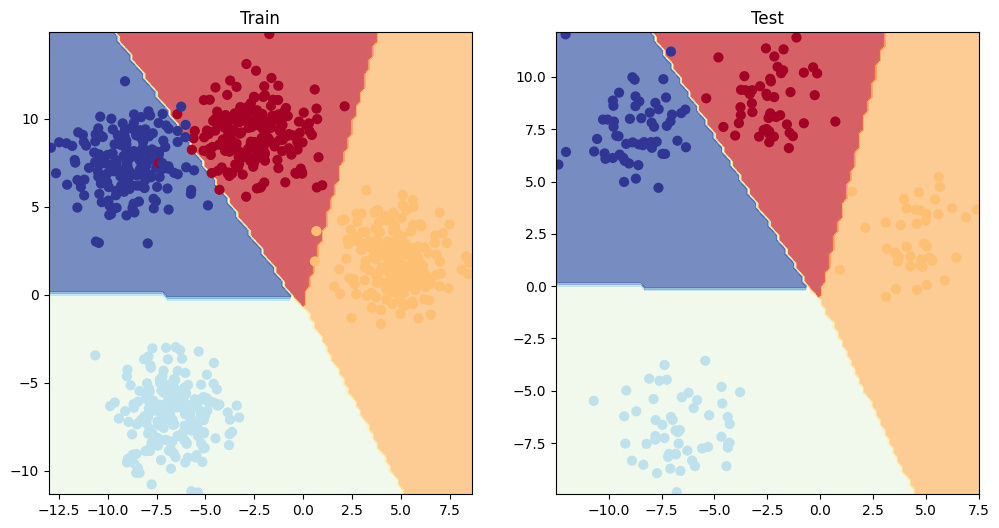

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## Classification metrics

`torchmetrics.Accuracy` finds the percentage of correct predictions.  
`torchmetrics.Precision` finds the proportion of true positives over the total number of samples.  
`torchmetrics.Recall` finds the proporition of true positives over the total number of true positives and false negatives (model predicts `0` when it should have been `1`).  
`torchmetrics.F1Score` finds the f1-score, which is defined as $\frac{precision \cdot recall}{precision + recall}$.  
`torchmetrics.ConfusionMatrix` creates a matrix whose rows and columns are actual and predicted values respectively, with each cell containing the number of samples of that combination of actual and predicted values.  
`sklearn.metrics.classification_report()` combines precision, recall, and f1-score.